# importing drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# installing torchvision and opencv-python

In [ ]:
!pip install torch torchvision opencv-python

# creating directories

In [ ]:
!mkdir -p /content/dataset/train/real
!mkdir -p /content/dataset/train/fake
!mkdir -p /content/dataset/val/real
!mkdir -p /content/dataset/val/fake

# uploading the kaggle api file

In [ ]:
# from google.colab import files
# files.upload()  # Upload kaggle.json here
!mkdir -p ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/OpenCV_Project/kaggle.json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# moving the kaggle file to kaggle dir

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory


# downloading the datasets from kaggle

In [ ]:
# !kaggle datasets download -d manjilkarki/deepfake-and-real-images -p /content/dataset
!kaggle datasets download -d manjilkarki/deepfake-and-real-images -p "/content/drive/MyDrive/Colab Notebooks/OpenCV_Project/Datasets"

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
 99% 1.67G/1.68G [00:11<00:00, 118MB/s]
100% 1.68G/1.68G [00:11<00:00, 163MB/s]


In [ ]:
# !unzip -q /content/dataset/deepfake-and-real-images.zip -d /content/dataset
!unzip -q "/content/drive/MyDrive/Colab Notebooks/OpenCV_Project/Datasets/deepfake-and-real-images.zip" -d "/content/dataset"

In [ ]:
# !unzip "/content/drive/MyDrive/Colab Notebooks/OpenCV_Project/Datasets/deepfake-and-real-images.zip" -d "/content/drive/MyDrive/Colab Notebooks/OpenCV_Project/Datasets"

Archive:  /content/drive/MyDrive/Colab Notebooks/OpenCV_Project/Datasets/deepfake-and-real-images.zip
replace /content/drive/MyDrive/Colab Notebooks/OpenCV_Project/Datasets/Dataset/Test/Fake/fake_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# correcting the directories

In [ ]:
# Remove any existing empty folders
!rm -rf /content/dataset/train
!rm -rf /content/dataset/val

# Create correct structure with symlinks
!mkdir -p /content/dataset/train
!mkdir -p /content/dataset/val

!ln -s /content/dataset/Dataset/Train/Real /content/dataset/train/real
!ln -s /content/dataset/Dataset/Train/Fake /content/dataset/train/fake
!ln -s /content/dataset/Dataset/Validation/Real /content/dataset/val/real
!ln -s /content/dataset/Dataset/Validation/Fake /content/dataset/val/fake


In [ ]:
# This script copies the first 1000 images from the
# original dataset to a new, clean directory structure.
# This is much faster than processing the full dataset.

# 1. Remove any existing destination folders to ensure a clean start.
# The 'rm -rf' command recursively deletes the directories and their contents.
!rm -rf /content/dataset/train
!rm -rf /content/dataset/val

# 2. Create the new destination folder structure.
# The '-p' flag ensures that parent directories are created as needed.
!mkdir -p /content/dataset/train/real
!mkdir -p /content/dataset/train/fake
!mkdir -p /content/dataset/val/real
!mkdir -p /content/dataset/val/fake

# 3. Copy the first 1000 images for each category.
# 'ls' lists the files, 'head -n 1000' selects the first 1000 lines (filenames),
# and 'xargs -I {} cp' copies each filename to the new destination.

# Copy 1000 real training images
!ls /content/dataset/Dataset/Train/Real | head -n 5000 | xargs -I {} cp "/content/dataset/Dataset/Train/Real/{}" "/content/dataset/train/real/"

# Copy 1000 fake training images
!ls /content/dataset/Dataset/Train/Fake | head -n 5000 | xargs -I {} cp "/content/dataset/Dataset/Train/Fake/{}" "/content/dataset/train/fake/"

# Copy 1000 real validation images
!ls /content/dataset/Dataset/Validation/Real | head -n 500 | xargs -I {} cp "/content/dataset/Dataset/Validation/Real/{}" "/content/dataset/val/real/"

# Copy 1000 fake validation images
!ls /content/dataset/Dataset/Validation/Fake | head -n 500 | xargs -I {} cp "/content/dataset/Dataset/Validation/Fake/{}" "/content/dataset/val/fake/"


In [ ]:
# !ls /content/dataset/train/real | head
!ls /content/dataset/train/real | wc -l

5000


In [ ]:
import os

# List folder contents
for root, dirs, files in os.walk("/content/dataset"):
    print(root, len(files), "files")


In [ ]:
!pwd

/content


# check for bad images

In [ ]:
import os
import cv2

def check_images_in_dir(root_dir):
    bad_files = []
    for subdir, _, files in os.walk(root_dir):
        for f in files:
            path = os.path.join(subdir, f)
            img = cv2.imread(path)
            if img is None:
                bad_files.append(path)
    print(f"Total bad files: {len(bad_files)}")
    for bf in bad_files:
        print(bf)

# Example usage:
check_images_in_dir("/content/dataset/Dataset/Train")


Total bad files: 0


# EDA

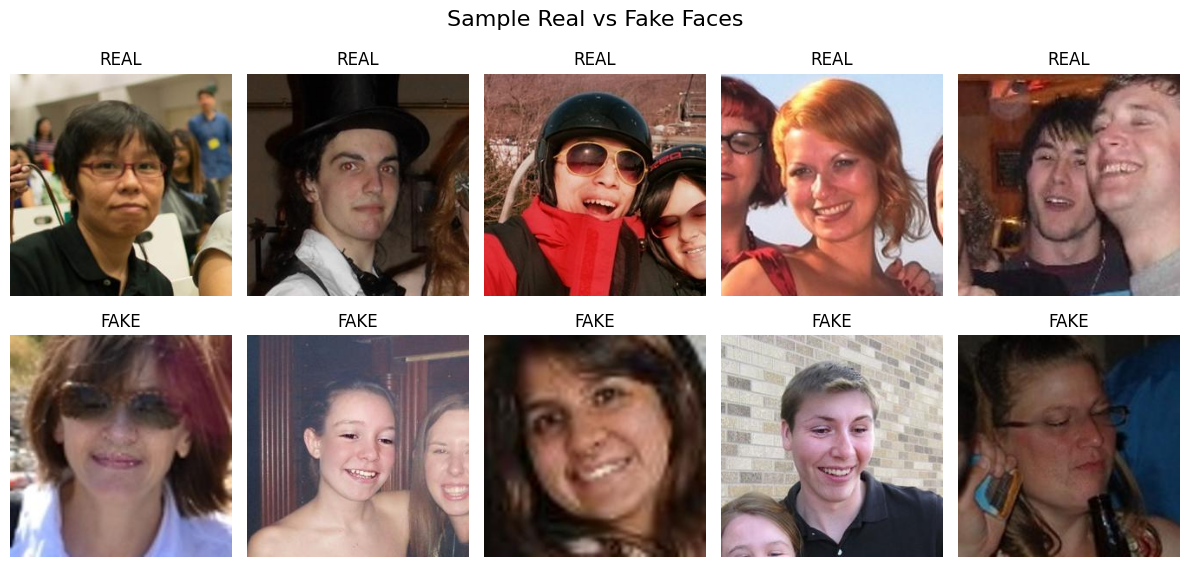

In [ ]:
import matplotlib.pyplot as plt
import cv2
import glob
import random

# Paths
real_path = "/content/dataset/Dataset/Train/Real/*.jpg"
fake_path = "/content/dataset/Dataset/Train/Fake/*.jpg"

# Pick random samples
real_images = random.sample(glob.glob(real_path), 5)
fake_images = random.sample(glob.glob(fake_path), 5)

# Plot
plt.figure(figsize=(12, 6))

for i, img_path in enumerate(real_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title("REAL")
    plt.axis("off")

for i, img_path in enumerate(fake_images):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 5, 5+i+1)
    plt.imshow(img)
    plt.title("FAKE")
    plt.axis("off")

plt.suptitle("Sample Real vs Fake Faces", fontsize=16)
plt.tight_layout()
plt.show()


# deepfake train file

In [ ]:
%%writefile deepfake_train.py
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Deepfake detection via Computer-Vision Features + Pairwise (Siamese) Learning
- Gabor-like preprocessing
- Feature extraction (HSV/RGB stats, luminance, histogram, variance, edges, DCT energy)
- (Optional) Fuzzy C-means cluster centroids as features
- Siamese MLP with Contrastive Loss (pairwise learning)

This is a practical, dependency-light implementation inspired by:
- Gabor-based preprocessing and fuzzy-clustering feature extraction :contentReference[oaicite:5]{index=5} :contentReference[oaicite:6]{index=6}
- Pairwise (Siamese) training with contrastive loss for deepfake discrimination :contentReference[oaicite:7]{index=7}
"""

import os
import math
import glob
import random
import argparse
from typing import List, Tuple

import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


# ---------------------------
# Gabor-based preprocessing
# ---------------------------
def gabor_preprocess(img_bgr: np.ndarray) -> np.ndarray:
    """Apply a small bank of Gabor kernels + Gaussian blur to enhance artifacts.
    Based on the paper’s idea of Gabor filter + Gaussian rule (practical version). :contentReference[oaicite:8]{index=8}
    """
    if img_bgr is None:
        raise ValueError("Invalid image")

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)

    # Small Gabor bank (frequencies/orientations)
    ksize = 9
    sigmas = [2.0, 3.0]
    thetas = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # 0°, 45°, 90°, 135°
    lambdas = [6.0, 8.0]
    gammas = [0.5, 0.8]

    accum = np.zeros_like(img_gray, dtype=np.float32)
    count = 0
    for sigma in sigmas:
        for theta in thetas:
            for lam in lambdas:
                for gamma in gammas:
                    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lam, gamma, 0, ktype=cv2.CV_32F)
                    resp = cv2.filter2D(img_gray, cv2.CV_32F, kernel)
                    accum += np.abs(resp)
                    count += 1

    if count > 0:
        accum /= count

    # Normalize to 0..255 and return as uint8
    accum = cv2.normalize(accum, None, 0, 255, cv2.NORM_MINMAX)
    return accum.astype(np.uint8)


# ---------------------------
# Fuzzy C-means (optional)
# ---------------------------
def fuzzy_c_means_intensity(img_gray: np.ndarray, c: int = 3, m: float = 2.0, iters: int = 10, seed: int = 0) -> np.ndarray:
    """Very small FCM on grayscale intensities per image; return sorted cluster centers (c,).
    This aligns with the paper’s fuzzy clustering-based feature extraction concept. :contentReference[oaicite:9]{index=9}
    """
    rng = np.random.default_rng(seed)
    x = img_gray.reshape(-1).astype(np.float32)
    # Initialize centers by random picks
    centers = rng.choice(x, size=c, replace=False).astype(np.float32)

    # Initialize membership uniformly
    U = rng.random((c, x.shape[0])).astype(np.float32)
    U = U / (U.sum(axis=0, keepdims=True) + 1e-8)

    for _ in range(iters):
        # Update centers
        um = U ** m
        centers = (um @ x) / (um.sum(axis=1) + 1e-8)

        # Update membership
        dist = np.maximum(np.abs(x[None, :] - centers[:, None]), 1e-6)  # (c, N)
        inv = 1.0 / (dist + 1e-12)
        inv_power = inv ** (2.0 / (m - 1.0))
        U = inv_power / (inv_power.sum(axis=0, keepdims=True) + 1e-8)

    return np.sort(centers)


# ---------------------------
# Feature Extraction
# ---------------------------
def dct_energy_features(img_gray: np.ndarray) -> Tuple[float, float]:
    """Compute total and high-frequency energy ratios from 2D DCT (image-level)."""
    # Resize to manageable square
    g = cv2.resize(img_gray, (128, 128), interpolation=cv2.INTER_AREA).astype(np.float32)
    # 2D DCT
    dct = cv2.dct(g)
    total_energy = float(np.sum(dct**2) + 1e-8)
    # Define low-frequency window (e.g., 16x16 top-left)
    lf = dct[:16, :16]
    low_energy = float(np.sum(lf**2) + 1e-8)
    high_energy = total_energy - low_energy
    return total_energy, high_energy / total_energy


def edge_density(img_gray: np.ndarray) -> float:
    edges = cv2.Canny(img_gray, 50, 150)
    return float(np.mean(edges > 0))


def luminance_mean_std(img_bgr: np.ndarray) -> Tuple[float, float]:
    yuv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    y = yuv[:, :, 0]
    return float(np.mean(y)), float(np.std(y))


def color_stats(img_bgr: np.ndarray) -> List[float]:
    # RGB mean/std
    means = [float(np.mean(img_bgr[:, :, i])) for i in range(3)]
    stds = [float(np.std(img_bgr[:, :, i])) for i in range(3)]
    # HSV mean/std
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    means_hsv = [float(np.mean(hsv[:, :, i])) for i in range(3)]
    stds_hsv = [float(np.std(hsv[:, :, i])) for i in range(3)]
    return means + stds + means_hsv + stds_hsv


def gray_histogram(img_gray: np.ndarray, bins: int = 32) -> np.ndarray:
    hist = cv2.calcHist([img_gray], [0], None, [bins], [0, 256]).reshape(-1)
    hist = hist / (np.sum(hist) + 1e-8)
    return hist.astype(np.float32)


def extract_features(img_path: str, use_fcm: bool = True, fcm_clusters: int = 3) -> np.ndarray:
    """
    End-to-end feature extractor:
    1. Gabor preprocessing
    2. Extract color, luminance, histogram, variance, edges, DCT energy
    3. Optionally add Fuzzy C-means cluster centers as extra features

    Parameters:
        img_path (str): Path to the input image.
        use_fcm (bool): Whether to include fuzzy C-means features.
        fcm_clusters (int): Number of clusters for FCM.

    Returns:
        np.ndarray: Feature vector.
    """
    # Read image in BGR format
    bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(f"Cannot read image: {img_path}")

    # 1️⃣ Preprocess using Gabor filters
    pre = gabor_preprocess(bgr)

    # 2️⃣ Base features (no reference images needed)
    rgb_hsv_stats = color_stats(bgr)                     # 12 features
    lum_mean, lum_std = luminance_mean_std(bgr)          # 2 features
    hist = gray_histogram(pre, bins=32)                  # 32 features
    var = float(np.var(pre))                             # 1 feature
    edge = edge_density(pre)                             # 1 feature
    dct_total, dct_high_ratio = dct_energy_features(pre) # 2 features

    # Combine base features
    feats = np.array(
        rgb_hsv_stats + [lum_mean, lum_std, var, edge, dct_total, dct_high_ratio],
        dtype=np.float32
    )
    feats = np.concatenate([feats, hist], axis=0)

    # 3️⃣ Optional: Fuzzy C-means cluster centers as features
    if use_fcm:
        centers = fuzzy_c_means_intensity(
            pre,
            c=fcm_clusters,
            m=2.0,
            iters=8,
            seed=0
        )  # Shape: (fcm_clusters,)
        feats = np.concatenate([feats, centers.astype(np.float32)], axis=0)

    return feats
# ---------------------------
# Dataset that yields PAIRS
# ---------------------------
class PairDataset(Dataset):
    def __init__(self, real_paths: List[str], fake_paths: List[str], use_fcm=True, fcm_clusters=3, cache=True):
        self.real_paths = real_paths
        self.fake_paths = fake_paths
        self.use_fcm = use_fcm
        self.fcm_clusters = fcm_clusters
        self.cache = cache
        self._feat_cache = {}

        self.all = [(p, 1) for p in real_paths] + [(p, 0) for p in fake_paths]
        assert len(self.all) > 1, "Not enough images"

        # Balance counts for pair sampling
        self.real_idx = [i for i, (_, y) in enumerate(self.all) if y == 1]
        self.fake_idx = [i for i, (_, y) in enumerate(self.all) if y == 0]

        # Determine feature dimension
        sample_feat = self._featurize(self.all[0][0])
        self.feat_dim = sample_feat.shape[0]

    def _featurize(self, path: str) -> np.ndarray:
        if self.cache and path in self._feat_cache:
            return self._feat_cache[path]
        feat = extract_features(path, use_fcm=self.use_fcm, fcm_clusters=self.fcm_clusters)
        if self.cache:
            self._feat_cache[path] = feat
        return feat

    def __len__(self):
        # Number of pairs per epoch (you can tune this)
        return max(2 * len(self.all), 1000)

    def __getitem__(self, idx):
        # Alternate between genuine (same class) and impostor (different class) pairs
        genuine = (idx % 2 == 0)

        if genuine:
            # pick class
            cls = random.choice([0, 1])  # 0 fake, 1 real
            pool = self.real_idx if cls == 1 else self.fake_idx
            i1, i2 = random.sample(pool, 2) if len(pool) >= 2 else (pool[0], pool[0])
        else:
            i1 = random.choice(self.real_idx)
            i2 = random.choice(self.fake_idx)

        p1, y1 = self.all[i1]
        p2, y2 = self.all[i2]

        f1 = self._featurize(p1)
        f2 = self._featurize(p2)

        label = 1.0 if (y1 == y2) else 0.0  # pairwise label per paper (p=1 genuine, p=0 impostor) :contentReference[oaicite:12]{index=12}

        return (
            torch.from_numpy(f1).float(),
            torch.from_numpy(f2).float(),
            torch.tensor(label).float()
        )


# ---------------------------
# Siamese MLP + Contrastive Loss
# ---------------------------
class Encoder(nn.Module):
    def __init__(self, in_dim: int, hid=128, emb=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hid),
            nn.Linear(hid, hid),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(hid),
            nn.Linear(hid, emb)
        )

    def forward(self, x):
        return self.net(x)


class Siamese(nn.Module):
    def __init__(self, in_dim: int, hid=128, emb=64):
        super().__init__()
        self.enc = Encoder(in_dim, hid, emb)

    def forward(self, x1, x2):
        z1 = self.enc(x1)
        z2 = self.enc(x2)
        return z1, z2

def contrastive_loss(z1, z2, label, margin=1.0):
    # Per paper: E = ||z1 - z2||_2 ; L = 0.5 * p * E^2 + 0.5 * (1-p) * max(0, m - E)^2  :contentReference[oaicite:13]{index=13}
    d = torch.nn.functional.pairwise_distance(z1, z2, keepdim=False)
    pos = 0.5 * label * (d ** 2)
    neg = 0.5 * (1.0 - label) * torch.clamp(margin - d, min=0.0) ** 2
    return (pos + neg).mean(), d


# ---------------------------
# Utilities
# ---------------------------
def list_images(root: str) -> Tuple[List[str], List[str]]:
    real = sorted(glob.glob(os.path.join(root, "real", "*.*")))
    fake = sorted(glob.glob(os.path.join(root, "fake", "*.*")))
    # Filter by image extensions
    exts = {".jpg", ".jpeg", ".png", ".bmp"}
    real = [p for p in real if os.path.splitext(p)[1].lower() in exts]
    fake = [p for p in fake if os.path.splitext(p)[1].lower() in exts]
    return real, fake


def accuracy_from_dist(dists: torch.Tensor, labels: torch.Tensor, thresh: float = 0.8):
    # decide "genuine" if distance < thresh
    pred_genuine = (dists < thresh).float()
    correct = (pred_genuine == labels).float().mean().item()
    return correct


# ---------------------------
# Train / Eval
# ---------------------------
def train(args):
    # Data
    tr_real, tr_fake = list_images(os.path.join(args.data_root, "train"))
    va_real, va_fake = list_images(os.path.join(args.data_root, "val"))

    if len(tr_real) + len(tr_fake) < 4:
        raise RuntimeError("Need at least a few images per class under data_root/train/{real,fake}")

    train_ds = PairDataset(tr_real, tr_fake, use_fcm=not args.no_fcm, fcm_clusters=args.fcm_k, cache=True)
    val_ds = PairDataset(va_real, va_fake, use_fcm=not args.no_fcm, fcm_clusters=args.fcm_k, cache=True)

    train_loader = DataLoader(train_ds, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)
    val_loader = DataLoader(val_ds, batch_size=args.batch_size, shuffle=False, num_workers=0, drop_last=False)

    # Model
    model = Siamese(train_ds.feat_dim, hid=args.hid, emb=args.emb)
    device = torch.device("cuda" if torch.cuda.is_available() and not args.cpu else "cpu")
    model.to(device)

    # Optimizer
    opt = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=1e-4)

    best_val = 0.0
    for epoch in range(1, args.epochs + 1):
        model.train()
        total_loss = 0.0
        for f1, f2, y in train_loader:
            f1, f2, y = f1.to(device), f2.to(device), y.to(device)
            opt.zero_grad()
            z1, z2 = model(f1, f2)
            loss, d = contrastive_loss(z1, z2, y, margin=args.margin)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        # Validate
        model.eval()
        with torch.no_grad():
            all_d, all_y = [], []
            for f1, f2, y in val_loader:
                f1, f2 = f1.to(device), f2.to(device)
                z1, z2 = model(f1, f2)
                _, d = contrastive_loss(z1, z2, y.to(device), margin=args.margin)
                all_d.append(d.cpu())
                all_y.append(y)
            dists = torch.cat(all_d, dim=0)
            labels = torch.cat(all_y, dim=0)
            acc = accuracy_from_dist(dists, labels, thresh=args.thresh)

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch:02d} | train_loss={avg_loss:.4f} | val_pair_acc={acc*100:.2f}%")

        if acc > best_val:
            best_val = acc
            os.makedirs(args.out_dir, exist_ok=True)
            torch.save({"state_dict": model.state_dict(), "feat_dim": train_ds.feat_dim}, os.path.join(args.out_dir, "siamese_deepfake.pth"))
            print(f"  ✔ saved best model to {os.path.join(args.out_dir, 'siamese_deepfake.pth')}")

    print("Done.")


def build_argparser():
    p = argparse.ArgumentParser()
    p.add_argument("--data_root", type=str, required=True, help="root with train/ and val/ folders")
    p.add_argument("--epochs", type=int, default=10)
    p.add_argument("--batch_size", type=int, default=64)
    p.add_argument("--lr", type=float, default=1e-3)
    p.add_argument("--margin", type=float, default=1.0, help="contrastive loss margin (m)")
    p.add_argument("--thresh", type=float, default=0.8, help="distance threshold for genuine vs impostor")
    p.add_argument("--hid", type=int, default=128)
    p.add_argument("--emb", type=int, default=64)
    p.add_argument("--cpu", action="store_true")
    p.add_argument("--no_fcm", action="store_true", help="disable fuzzy C-means extra features")
    p.add_argument("--fcm_k", type=int, default=3, help="FCM clusters")
    p.add_argument("--out_dir", type=str, default="checkpoints")
    return p


if __name__ == "__main__":
    args = build_argparser().parse_args()
    random.seed(0); np.random.seed(0); torch.manual_seed(0)
    train(args)


Writing deepfake_train.py


# execute the deepfake_train.py (train,extract features)

In [ ]:
# !mkdir -p /content/dataset/train/real /content/dataset/train/fake
# !ls /content/dataset/Dataset/Train/Real | head -20000 | xargs -I{} cp /content/dataset/Dataset/Train/Real/{} /content/dataset/train/real/
# !ls /content/dataset/Dataset/Train/Fake | head -20000 | xargs -I{} cp /content/dataset/Dataset/Train/Fake/{} /content/dataset/train/fake/


!rm -rf /content/dataset/train
!rm -rf /content/dataset/val


!mkdir -p /content/dataset/train/real /content/dataset/train/fake
!mkdir -p /content/dataset/val/real /content/dataset/val/fake


# Copy real training images
!ls "/content/dataset/Dataset/Train/Real" | head -5000  | xargs -I {} cp "/content/dataset/Dataset/Train/Real/{}" "/content/dataset/train/real/"

# Copy fake training images
!ls "/content/dataset/Dataset/Train/Fake" | head -5000  | xargs -I {} cp "/content/dataset/Dataset/Train/Fake/{}" "/content/dataset/train/fake/"

# Copy real validation images
!ls "/content/dataset/Dataset/Validation/Real" | head -500  | xargs -I {} cp "/content/dataset/Dataset/Validation/Real/{}" "/content/dataset/val/real/"

# Copy fake validation images
!ls "/content/dataset/Dataset/Validation/Fake" | head -500  | xargs -I {} cp "/content/dataset/Dataset/Validation/Fake/{}" "/content/dataset/val/fake/"


In [ ]:
!python deepfake_train.py \
  --data_root /content/dataset \
  --epochs 3 \
  --batch_size 32 \
  --lr 0.001 \
  --out_dir /content/output


Epoch 01 | train_loss=0.2875 | val_pair_acc=49.95%
  ✔ saved best model to /content/output/siamese_deepfake.pth
Epoch 02 | train_loss=0.1602 | val_pair_acc=49.00%
Epoch 03 | train_loss=0.1565 | val_pair_acc=50.40%
  ✔ saved best model to /content/output/siamese_deepfake.pth
Done.


# anchors file

In [ ]:
%%writefile build_anchors.py
import os, glob, random, argparse, numpy as np, torch
from typing import List
from deepfake_train import extract_features, Siamese

def list_images(root: str) -> (List[str], List[str]):
    # robust to {real,Real} naming
    def subdir(options):
        for name in options:
            p = os.path.join(root, name)
            if os.path.isdir(p):
                return p
        raise FileNotFoundError(f"None of {options} found under {root}")
    real_dir = subdir(["real","Real"])
    fake_dir = subdir(["fake","Fake"])
    exts = {".jpg",".jpeg",".png",".bmp"}
    def collect(d):
        xs = []
        for p in glob.glob(os.path.join(d, "*.*")):
            if os.path.splitext(p)[1].lower() in exts:
                xs.append(p)
        return xs
    return sorted(collect(real_dir)), sorted(collect(fake_dir))

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--anchors_root", type=str, required=True, help="folder with {real,fake}")
    ap.add_argument("--weights", type=str, default="checkpoints/siamese_deepfake.pth")
    ap.add_argument("--out", type=str, default="anchors.npz")
    ap.add_argument("--hid", type=int, default=128)
    ap.add_argument("--emb", type=int, default=64)
    ap.add_argument("--per_class", type=int, default=200, help="number of anchors per class")
    ap.add_argument("--no_fcm", action="store_true")
    ap.add_argument("--fcm_k", type=int, default=3)
    ap.add_argument("--cpu", action="store_true")
    args = ap.parse_args()

    ckpt = torch.load(args.weights, map_location="cpu")
    feat_dim = ckpt["feat_dim"]
    device = torch.device("cpu" if args.cpu or not torch.cuda.is_available() else "cuda")

    model = Siamese(feat_dim, hid=args.hid, emb=args.emb).to(device)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    real_paths, fake_paths = list_images(args.anchors_root)
    random.seed(0)
    real_sample = random.sample(real_paths, min(args.per_class, len(real_paths)))
    fake_sample = random.sample(fake_paths, min(args.per_class, len(fake_paths)))

    def encode(paths):
        Z = []
        for p in paths:
            x = extract_features(p, use_fcm=not args.no_fcm, fcm_clusters=args.fcm_k)
            x = torch.from_numpy(x).float().unsqueeze(0).to(device)
            with torch.no_grad():
                z = model.enc(x)  # (1, emb)
            Z.append(z.cpu().numpy()[0])
        return np.stack(Z, axis=0)

    Z_real = encode(real_sample)
    Z_fake = encode(fake_sample)

    np.savez(args.out, Z_real=Z_real, Z_fake=Z_fake, real_paths=np.array(real_sample), fake_paths=np.array(fake_sample))
    print(f"Saved anchors to {args.out} | shapes: real {Z_real.shape}, fake {Z_fake.shape}")

if __name__ == "__main__":
    main()


Writing build_anchors.py


# execute anchor.py

In [ ]:
!ls checkpoints


ls: cannot access 'checkpoints': No such file or directory


In [ ]:
!python build_anchors.py \
  --anchors_root /content/dataset/Dataset/Validation \
  --weights /content/output/siamese_deepfake.pth \
  --per_class 200


Saved anchors to anchors.npz | shapes: real (200, 64), fake (200, 64)


# Evaluation file

In [ ]:
%%writefile eval.py
import os, glob, argparse, numpy as np, torch
from typing import List, Tuple
from deepfake_train import extract_features, Siamese

def list_images(root: str) -> Tuple[list, list]:
    def sub(options):
        for name in options:
            p = os.path.join(root, name)
            if os.path.isdir(p):
                return p
        raise FileNotFoundError(f"None of {options} found under {root}")
    real_dir = sub(["real","Real"])
    fake_dir = sub(["fake","Fake"])
    exts = {".jpg",".jpeg",".png",".bmp"}
    def collect(d):
        xs = []
        for p in glob.glob(os.path.join(d, "*.*")):
            if os.path.splitext(p)[1].lower() in exts:
                xs.append(p)
        return xs
    return sorted(collect(real_dir)), sorted(collect(fake_dir))

def metrics_from_cm(TP, TN, FP, FN):
    acc = (TP + TN) / max(TP + TN + FP + FN, 1)
    prec_real = TP / max(TP + FP, 1)
    rec_real  = TP / max(TP + FN, 1)
    f1_real   = 2*prec_real*rec_real / max(prec_real + rec_real, 1e-8)

    prec_fake = TN / max(TN + FN, 1)
    rec_fake  = TN / max(TN + FP, 1)
    f1_fake   = 2*prec_fake*rec_fake / max(prec_fake + rec_fake, 1e-8)

    return acc, (prec_real, rec_real, f1_real), (prec_fake, rec_fake, f1_fake)

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--test_root", type=str, required=True, help="folder with {Real,Fake}")
    ap.add_argument("--weights", type=str, default="checkpoints/siamese_deepfake.pth")
    ap.add_argument("--anchors", type=str, default="anchors.npz")
    ap.add_argument("--hid", type=int, default=128)
    ap.add_argument("--emb", type=int, default=64)
    ap.add_argument("--no_fcm", action="store_true")
    ap.add_argument("--fcm_k", type=int, default=3)
    ap.add_argument("--cpu", action="store_true")
    args = ap.parse_args()

    # model
    ckpt = torch.load(args.weights, map_location="cpu")
    feat_dim = ckpt["feat_dim"]
    device = torch.device("cpu" if args.cpu or not torch.cuda.is_available() else "cuda")
    model = Siamese(feat_dim, hid=args.hid, emb=args.emb).to(device)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    # anchors
    data = np.load(args.anchors, allow_pickle=True)
    Z_real = torch.from_numpy(data["Z_real"]).float().to(device)  # (Nr, emb)
    Z_fake = torch.from_numpy(data["Z_fake"]).float().to(device)  # (Nf, emb)

    # test images
    real_paths, fake_paths = list_images(args.test_root)

    def encode_one(path: str):
        x = extract_features(path, use_fcm=not args.no_fcm, fcm_clusters=args.fcm_k)
        x = torch.from_numpy(x).float().unsqueeze(0).to(device)
        with torch.no_grad():
            z = model.enc(x)  # (1, emb)
        return z[0]  # (emb,)

    TP = TN = FP = FN = 0

    # classify by average distance to each anchor class
    def predict_label(z):  # returns 1 for real, 0 for fake
        # mean L2 distance to each class anchors
        d_real = torch.cdist(z.unsqueeze(0), Z_real).mean().item()
        d_fake = torch.cdist(z.unsqueeze(0), Z_fake).mean().item()
        return 1 if d_real < d_fake else 0, d_real, d_fake

    # real images (label=1)
    for i, p in enumerate(real_paths, 1):
        z = encode_one(p)
        yhat, _, _ = predict_label(z)
        if yhat == 1: TP += 1
        else: FN += 1
        if i % 2000 == 0: print(f"Scored {i} real images...")

    # fake images (label=0)
    for i, p in enumerate(fake_paths, 1):
        z = encode_one(p)
        yhat, _, _ = predict_label(z)
        if yhat == 0: TN += 1
        else: FP += 1
        if i % 2000 == 0: print(f"Scored {i} fake images...")

    acc, (pr_r, rc_r, f1_r), (pr_f, rc_f, f1_f) = metrics_from_cm(TP, TN, FP, FN)
    print("\n=== Results on TEST ===")
    print(f"Confusion: TP={TP}, TN={TN}, FP={FP}, FN={FN}")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Real: Precision={pr_r:.3f} Recall={rc_r:.3f} F1={f1_r:.3f}")
    print(f"Fake: Precision={pr_f:.3f} Recall={rc_f:.3f} F1={f1_f:.3f}")

if __name__ == "__main__":
    main()


Overwriting eval.py


# Execute Eval.py

In [ ]:
!python eval.py \
  --test_root /content/dataset/Dataset/Test \
  --weights /content/output/siamese_deepfake.pth \
  --anchors anchors.npz


Scored 2000 real images...
Scored 4000 real images...
Scored 2000 fake images...
Scored 4000 fake images...

=== Results on TEST ===
Confusion: TP=1982, TN=3840, FP=1652, FN=3431
Accuracy: 53.39%
Real: Precision=0.545 Recall=0.366 F1=0.438
Fake: Precision=0.528 Recall=0.699 F1=0.602


# Prediction file


In [ ]:
%%writefile predict_one.py
import argparse, numpy as np, torch
from deepfake_train import extract_features, Siamese

def main():
    ap = argparse.ArgumentParser()
    ap.add_argument("--image", type=str, required=True)
    ap.add_argument("--weights", type=str, default="checkpoints/siamese_deepfake.pth")
    ap.add_argument("--anchors", type=str, default="anchors.npz")
    ap.add_argument("--hid", type=int, default=128)
    ap.add_argument("--emb", type=int, default=64)
    ap.add_argument("--no_fcm", action="store_true")
    ap.add_argument("--fcm_k", type=int, default=3)
    ap.add_argument("--cpu", action="store_true")
    args = ap.parse_args()

    ckpt = torch.load(args.weights, map_location="cpu")
    feat_dim = ckpt["feat_dim"]
    device = torch.device("cpu" if args.cpu or not torch.cuda.is_available() else "cuda")

    model = Siamese(feat_dim, hid=args.hid, emb=args.emb).to(device)
    model.load_state_dict(ckpt["state_dict"])
    model.eval()

    data = np.load(args.anchors, allow_pickle=True)
    Z_real = torch.from_numpy(data["Z_real"]).float().to(device)
    Z_fake = torch.from_numpy(data["Z_fake"]).float().to(device)

    x = extract_features(args.image, use_fcm=not args.no_fcm, fcm_clusters=args.fcm_k)
    x = torch.from_numpy(x).float().unsqueeze(0).to(device)
    with torch.no_grad():
        z = model.enc(x)[0]  # (emb,)

    d_real = torch.cdist(z.unsqueeze(0), Z_real).mean().item()
    d_fake = torch.cdist(z.unsqueeze(0), Z_fake).mean().item()
    pred = "REAL" if d_real < d_fake else "FAKE"
    print(f"Image: {args.image}")
    print(f"Prediction: {pred}")
    print(f"Avg distance -> real: {d_real:.4f} | fake: {d_fake:.4f}")

if __name__ == "__main__":
    main()


Overwriting predict_one.py


# Execute pred.py

In [ ]:

!python predict_one.py \
  --image /content/dataset/Dataset/Test/Fake/fake_1006.jpg \
  --weights /content/output/siamese_deepfake.pth \
  --anchors anchors.npz



Image: /content/dataset/Dataset/Test/Fake/fake_1006.jpg
Prediction: REAL
Avg distance -> real: 0.4420 | fake: 0.4421


# identify person in Video

In [ ]:
import cv2
import torch
import numpy as np
from deepfake_model import Siamese, extract_features, load_anchors  # assume utils

# Load model + anchors
ckpt = torch.load("output/siamese_deepfake.pth", map_location="cpu")
model = Siamese(ckpt["feat_dim"])
model.load_state_dict(ckpt["state_dict"])
model.eval()

anchors = np.load("anchors.npz")
real_emb = anchors["real"]
fake_emb = anchors["fake"]

# Video input/output
cap = cv2.VideoCapture("input_video.mp4")
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter("output_video.avi", fourcc, 25.0, (int(cap.get(3)), int(cap.get(4))))

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        face = frame[y:y+h, x:x+w]
        feats = extract_features_from_frame(face)   # same as training features
        feats = torch.tensor(feats).unsqueeze(0).float()

        with torch.no_grad():
            emb = model.enc(feats).numpy()

        # Distance to anchors
        d_real = np.linalg.norm(emb - real_emb.mean(axis=0))
        d_fake = np.linalg.norm(emb - fake_emb.mean(axis=0))

        label = "Real" if d_real < d_fake else "Fake"
        conf = d_fake / (d_real + d_fake) if label == "Real" else d_real / (d_real + d_fake)

        # Draw annotation
        color = (0,255,0) if label == "Real" else (0,0,255)
        cv2.rectangle(frame, (x,y), (x+w,y+h), color, 2)
        cv2.putText(frame, f"{label} ({conf:.2f})", (x, y-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    out.write(frame)

cap.release()
out.release()
cv2.destroyAllWindows()
